# Import

## Python

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as skl


from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble        import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import *


#Tricks to not show directory adress because of warnings, for final release
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

## Data

In [2]:
url = 'https://raw.githubusercontent.com/SylvianMunier/IBM-Data-Science-capstone-project/master/Data-Collisions.csv'
df = pd.read_csv(url)

C:\Users\Sylvian\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (33) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Data cleaning 

In [17]:
# After some work on rough draft and analysis of the metadata, the following decision were made:
# Keeping the column of interest:
df_kept = df[["SEVERITYCODE","ROADCOND","LIGHTCOND","JUNCTIONTYPE"]]

#Cleaning unusable lines:
#Concerning the road condition:
#For eventual need, every step is kept and saved into a special data frame.
df2 = df_kept
df3 = df2[(df2["ROADCOND"]=="Dry")|(df2["ROADCOND"]=="Wet") |\
          (df2["ROADCOND"]=="Ice")|(df2["ROADCOND"]=="Snow/Slush") | (df2["ROADCOND"]=="Standing Water")]

#Concerning the light condition:
df4 = df3[(df3["LIGHTCOND"]=="Daylight") | (df3["LIGHTCOND"]=="Dark - Street Lights On") | \
          (df3["LIGHTCOND"]=="Dusk") | (df3["LIGHTCOND"]=="Dawn") | (df3["LIGHTCOND"]=="Dark - No Street Lights") |\
          (df3["LIGHTCOND"]=="Dark Street Lights Off")]

#Concerning the junction type:
df_cleaned = df4[(df4["JUNCTIONTYPE"]=="Mid-Block (not related to intersection)") | \
        (df4["JUNCTIONTYPE"]=="At Intersection (intersection related)") | \
        (df4["JUNCTIONTYPE"]=="Mid-Block (but intersection related)") | \
        (df4["JUNCTIONTYPE"]=="Driveway Junction") | \
        (df4["JUNCTIONTYPE"]=="At Intersection (but not related to intersection)") | \
        (df4["JUNCTIONTYPE"]=="Ramp Junction")]

df_cleaned.to_csv(r'C:\Users\Sylvian\Documents\GitHub\IBM-Data-Science-capstone-project\DataCleaned.csv',index=False)
test = pd.read_csv(r'C:\Users\Sylvian\Documents\GitHub\IBM-Data-Science-capstone-project\DataCleaned.csv')
print(test.head())
print(df_cleaned.head())

   SEVERITYCODE ROADCOND                LIGHTCOND  \
0             2      Wet                 Daylight   
1             1      Wet  Dark - Street Lights On   
2             1      Dry                 Daylight   
3             1      Dry                 Daylight   
4             2      Wet                 Daylight   

                              JUNCTIONTYPE  
0   At Intersection (intersection related)  
1  Mid-Block (not related to intersection)  
2  Mid-Block (not related to intersection)  
3  Mid-Block (not related to intersection)  
4   At Intersection (intersection related)  
   SEVERITYCODE ROADCOND                LIGHTCOND  \
0             2      Wet                 Daylight   
1             1      Wet  Dark - Street Lights On   
2             1      Dry                 Daylight   
3             1      Dry                 Daylight   
4             2      Wet                 Daylight   

                              JUNCTIONTYPE  
0   At Intersection (intersection related)  
1 

# Analysis

## Transforming data set into numerical only data

In [4]:
#For later use, the data frame of road condition is  kept as an image. 
#We will use them to recall later what every numerical value refers to. 
#(KNN needs to have only numerical values, so text will be replaced by numbers)
df_road_con_conv = df_cleaned["ROADCOND"].value_counts().to_frame().reset_index()
df_road_con_conv.index+=1
df_road_con_conv

,index,ROADCOND
1,Dry,119728
2,Wet,45675
3,Ice,1107
4,Snow/Slush,840
5,Standing Water,104


In [5]:
df_light_conv = df_cleaned["LIGHTCOND"].value_counts().to_frame().reset_index()
df_light_conv.index+=1
df_light_conv

,index,LIGHTCOND
1,Daylight,111583
2,Dark - Street Lights On,46481
3,Dusk,5623
4,Dawn,2391
5,Dark - No Street Lights,1376


In [6]:
df_junction_conv = df_cleaned["JUNCTIONTYPE"].value_counts().to_frame().reset_index()
df_junction_conv.index+=1
df_junction_conv

,index,JUNCTIONTYPE
1,Mid-Block (not related to intersection),74984
2,At Intersection (intersection related),59343
3,Mid-Block (but intersection related),21198
4,Driveway Junction,9982
5,At Intersection (but not related to intersection),1794
6,Ramp Junction,153


In [7]:
#Replacing text by numerical values

df_cleaned = df_cleaned.replace({"ROADCOND" : { "Dry" : 1, "Wet" : 2, "Ice" : 3, "Snow/Slush" : 4, "Standing Water" : 5 }})
df_cleaned = df_cleaned.replace({"LIGHTCOND" : { "Daylight" : 1, "Dark - Street Lights On" : 2, "Dusk" : 3, "Dawn" : 4, "Dark - No Street Lights" : 5 }})
df_cleaned = df_cleaned.replace({"JUNCTIONTYPE" : { "Mid-Block (not related to intersection)" : 1, "At Intersection (intersection related)" : 2, "Mid-Block (but intersection related)" : 3, "Driveway Junction" : 4, "At Intersection (but not related to intersection)" : 5, "Ramp Junction" : 6 }})

df_cleaned.head()

,SEVERITYCODE,ROADCOND,LIGHTCOND,JUNCTIONTYPE
0,2,2,1,2
1,1,2,2,1
2,1,1,1,1
3,1,1,1,1
4,2,2,1,2


## Separating training data and testing data

In [8]:
#Initializing variable for the model
X = df_cleaned.drop(["SEVERITYCODE"],axis=1)
y = df_cleaned["SEVERITYCODE"].values

print("X\n",X.head(),"\ny\n",y[0:5])

X
    ROADCOND  LIGHTCOND  JUNCTIONTYPE
0         2          1             2
1         2          2             1
2         1          1             1
3         1          1             1
4         2          1             2 
y
 [2 1 1 1 2]


In [9]:
#Might want to allocate 70%:train 15%:validation 15%:test. Might also want to validate that between 80% train and 20% test without validate, also try different percentage
#Peut-être pas nécessaire avec du cross-validation like k-fold ? ==> faire une comparaison également

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)
print("X_train size is ", X_train.shape, "\n", "X_test size is ", X_test.shape, "\n",
      "y_train size is ", y_train.shape, "\n", "y_test size is ", y_test.shape)

X_train = preprocessing.StandardScaler().fit(X_train).transform(X_train.astype(float))

X_test = preprocessing.StandardScaler().fit(X_test).transform(X_test.astype(float))

X_train size is  (133963, 3) 
 X_test size is  (33491, 3) 
 y_train size is  (133963,) 
 y_test size is  (33491,)


## K-Nearest Neighbours analysis

In [10]:
Ks = 10   
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = skl.neighbors.KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)

    
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

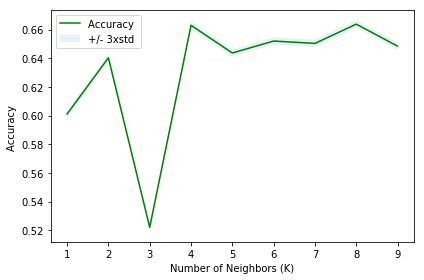

The best accuracy was with 0.663820130781404 with k= 8


In [11]:
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1) 

In [12]:
#The predictive algorithm, you can modify the code to add a scan() function to let the user enter its own data
neigh = skl.neighbors.KNeighborsClassifier(n_neighbors = 8).fit(X_train,y_train)
yhat=neigh.predict(X_test)
mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)
print("The accuracy with k=8 is %0.3f" %mean_acc.max())

The accuracy with k=8 is 0.664


In [13]:
#As 4 neighbours seems close, we also try this one
neigh = skl.neighbors.KNeighborsClassifier(n_neighbors = 4).fit(X_train,y_train)
yhat=neigh.predict(X_test)
mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)
print("The accuracy with k=4 is %0.3f" %mean_acc.max())

The accuracy with k=4 is 0.664


## Random Forest

In [34]:
# Réécrire ça
#def rfr_model(X, y):
# Perform Grid-Search
 #   gsc = GridSearchCV(
  #      estimator=RandomForestRegressor(),
   #     param_grid={
    #        'max_depth': range(3,7),#change to none
     #       'n_estimators': (10, 50, 100, 1000),#change with my algorithm
      #  },
       # cv=5, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)#Vérifier ça
    
#    grid_result = gsc.fit(X, y)
 #   best_params = grid_result.best_params_
    
  #  rfr = RandomForestRegressor(max_depth=best_params["max_depth"], n_estimators=best_params["n_estimators"],                               random_state=False, verbose=False)
# Perform K-Fold CV
   #scores = cross_val_score(rfr, X, y, cv=10, scoring='neg_mean_absolute_error')

    #return scores

gsc = GridSearchCV(
        estimator=RandomForestClassifier(),
        param_grid={
            'criterion':('gini', 'entropy'),
            'n_estimators': (10, 50, 100),
            'min_samples_split':(2,10),
            
        },
        cv=5, scoring='accuracy', verbose=3, n_jobs=-1,return_train_score=True)
    
grid_result = gsc.fit(X, y)
best_params = grid_result.best_params_
    
rfr = RandomForestClassifier(criterion=best_params["criterion"], n_estimators=best_params["n_estimators"],min_samples_split=best_params["min_samples_split"],                               random_state=False, verbose=False)
# Perform K-Fold CV
scores = cross_val_score(rfr, X, y, cv=5, scoring='accuracy')
print(scores)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   29.4s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  1.7min finished


[0.66980174 0.66971217 0.66963273 0.66981188 0.66915497]


In [21]:
scores = cross_val_score(rfr, X, y, cv=10, scoring='normalized_mutual_info_score')
print(scores)

C:\Users\Sylvian\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
C:\Users\Sylvian\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
C:\Users\Sylvian\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
C:\Users\Sylvian\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI wi

[3.28325439e-03 3.87231429e-05 3.00527721e-04 1.18726574e-03
 3.47269822e-03 3.28325439e-03 1.49647055e-03 1.18726696e-03
 3.28192255e-04 2.94024857e-04]


C:\Users\Sylvian\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


As I see estimators like 10, 50, 100, 1000, I will creat an algorithm that start at 1 say, then compute one time, multiply the forest by 10, if it is better, then again by 10 times (or else, I will try, maybe by 2 is better, use the function to calculate computation time and experiment), else take the mid point ==> 10 et 100, 100 est moins bon que 10, alors je prends 55. 55 est meilleur que 100 mais moins bon que 10, alors c'est compris entre 10 et 55, sinon entre 50 et 100. Ensuite on a 65/2=32 entier. Pour chaque étape, afficher le nombre et le score pour être sûr que la technique fonctionne bien.

In [24]:
print(best_params)

{'criterion': 'entropy', 'min_samples_split': 2, 'n_estimators': 100}


In [25]:
rfr = RandomForestClassifier(criterion='entropy', n_estimators=100,min_samples_split=2,
                             random_state=False, verbose=False)
# Perform K-Fold CV
scores = cross_val_score(rfr, X, y, cv=10, scoring='normalized_mutual_info_score')
print(scores)

C:\Users\Sylvian\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
C:\Users\Sylvian\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
C:\Users\Sylvian\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
C:\Users\Sylvian\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI wi

[3.28325439e-03 3.87231429e-05 3.00527721e-04 1.18726574e-03
 3.47269822e-03 3.28325439e-03 1.49647055e-03 1.18726696e-03
 3.28192255e-04 2.94024857e-04]


C:\Users\Sylvian\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


In [31]:
sorted(skl.metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'brier_score_loss',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'mutual_info_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'v_measure_score']